# Neural Network from Scratch in TensorFlow 2.x

# Importing Libraries

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

print('TensorFlow Version:', tf.__version__)

TensorFlow Version: 2.4.1


# Initializing Neural Network

In [3]:
class NeuralNetwork:
    def __init__(self, layers):
        self.layers = layers
        self.L = len(layers)
        self.num_features = layers[0]
        self.num_classes = layers[-1]
        
        self.W = {}
        self.b = {}
        
        self.dW = {}
        self.db = {}
        
        self.setup()
        
    def setup(self):
        for i in range(1, self.L):
            self.W[i] = tf.Variable(tf.random.normal(shape=(self.layers[i], self.layers[i-1])))
            self.b[i] = tf.Variable(tf.random.normal(shape=(self.layers[i], 1)))

# Forward Pass

In [4]:
class NeuralNetwork(NeuralNetwork):
    def forward_pass(self, A):
        A = tf.convert_to_tensor(A, dtype=tf.float32)
        for i in range(1, self.L):
            Z = tf.matmul(A, tf.transpose(self.W[i])) + tf.transpose(self.b[i])
            if i != self.L-1:
                A = tf.nn.relu(Z)
            else:
                A = Z
        return A

# Computing Loss and Updating Parameters

In [5]:
class NeuralNetwork(NeuralNetwork):
    def compute_loss(self, A, Y):
        return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(Y, A))
    
    def update_params(self, lr):
        for i in range(1, self.L):
            self.W[i].assign_sub(lr * self.dW[i])
            self.b[i].assign_sub(lr * self.db[i])

# Predict and Model Summary

In [6]:
class NeuralNetwork(NeuralNetwork):
    def predict(self, X):
        A = self.forward_pass(X)
        return tf.argmax(tf.nn.softmax(A), axis=1)
    
    def info(self):
        num_params = 0
        for i in range(1, self.L):
            num_params += self.W[i].shape[0] * self.W[i].shape[1]
            num_params += self.b[i].shape[0]
        print('Input Features:', self.num_features)
        print('Number of Classes:', self.num_classes)
        print('Hidden Layers:')
        print('--------------')
        for i in range(1, self.L-1):
            print('Layer {}, Units {}'.format(i, self.layers[i]))
        print('--------------')
        print('Number of parameters:', num_params)

# Training on Batch

In [7]:
class NeuralNetwork(NeuralNetwork):
    def train_on_batch(self, X, Y, lr):
        X = tf.convert_to_tensor(X, dtype=tf.float32)
        Y = tf.convert_to_tensor(Y, dtype=tf.float32)
        
        with tf.GradientTape(persistent=True) as tape:
            A = self.forward_pass(X)
            loss = self.compute_loss(A, Y)
        for key in self.W.keys():
            self.dW[key] = tape.gradient(loss, self.W[key])
            self.db[key] = tape.gradient(loss, self.b[key])
        del tape
        self.update_params(lr)
        
        return loss.numpy()

# Training on MNIST Data

In [8]:
class NeuralNetwork(NeuralNetwork):
    def train(self, x_train, y_train, x_test, y_test, epochs, steps_per_epoch, batch_size, lr):
        history = {
            'val_loss': [],
            'train_loss': [],
            'val_acc': []
        }
        
        for e in range(0, epochs):
            epoch_train_loss = 0.
            print('Epoch {}'.format(e), end='.')
            for i in range(0, steps_per_epoch):
                x_batch = x_train[i*batch_size:(i+1)*batch_size]
                y_batch = y_train[i*batch_size:(i+1)*batch_size]
                batch_loss = self.train_on_batch(x_batch, y_batch, lr)
                epoch_train_loss += batch_loss
                
                if i%int(steps_per_epoch/10) == 0:
                    print(end='.')
                    
            history['train_loss'].append(epoch_train_loss/steps_per_epoch)
            
            val_A = self.forward_pass(x_test)
            history['val_loss'].append(self.compute_loss(val_A, y_test).numpy())
            
            val_preds = self.predict(x_test)
            history['val_acc'].append(np.mean(np.argmax(y_test, axis=1) == val_preds.numpy()))
            print('Val Acc:', history['val_acc'][-1])
        return history

# Load MNIST Data for Training

In [9]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = np.reshape(x_train, (x_train.shape[0], 784))/ 255.0 # normalize
x_test = np.reshape(x_test, (x_test.shape[0], 784))/ 255.0
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

11493376/11490434 [==============================] - 0s 0us/step


In [10]:
def plot_random_examples(x, y, p=None):
    indices = np.random.choice(range(0, x.shape[0]), 10)
    y = np.argmax(y, axis=1)
    if p is None:
        p = y
    plt.figure(figsize=(10, 5))
    for i, index in enumerate(indices):
        plt.subplot(2, 5, i+1)
        plt.imshow(x[index].reshape((28, 28)), cmap='binary')
        plt.xticks([])
        plt.yticks([])
        if y[index] == p[index]:
            col = 'g'
        else:
            col = 'r'
        plt.xlabel(str(p[index]), color=col)
    return plt

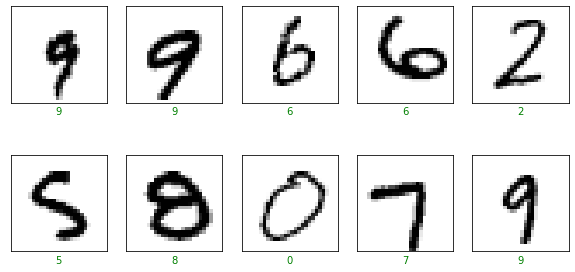

In [11]:
plot_random_examples(x_train, y_train).show()

In [15]:
net = NeuralNetwork([784, 256, 128, 10])
net.info()

Input Features: 784
Number of Classes: 10
Hidden Layers:
--------------
Layer 1, Units 256
Layer 2, Units 128
--------------
Number of parameters: 235146


In [16]:
batch_size = 120
epochs = 10
steps_per_epoch = int(x_train.shape[0]/batch_size)
lr = 3e-3

print('Steps per epoch:', steps_per_epoch)

Steps per epoch: 500


In [17]:
history = net.train(
    x_train, y_train,
    x_test, y_test,
    epochs, steps_per_epoch,
    batch_size, lr
)

Epoch 0...........Val Acc: 0.8459
Epoch 1...........Val Acc: 0.867
Epoch 2...........Val Acc: 0.8803
Epoch 3...........Val Acc: 0.8844
Epoch 4...........Val Acc: 0.8846
Epoch 5...........Val Acc: 0.8884
Epoch 6...........Val Acc: 0.8906
Epoch 7...........Val Acc: 0.8938
Epoch 8...........Val Acc: 0.8952
Epoch 9...........Val Acc: 0.8983


# Predictions & Results

In [18]:
def plot_results(history):
    plt.figure(figsize=(12, 4))
    epochs = len(history['val_loss'])
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), history['val_loss'], label='Val Loss')
    plt.plot(range(epochs), history['train_loss'], label='Train Loss')
    plt.xticks(list(range(epochs)))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), history['val_acc'], label='Val Acc')
    plt.xticks(list(range(epochs)))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    return plt

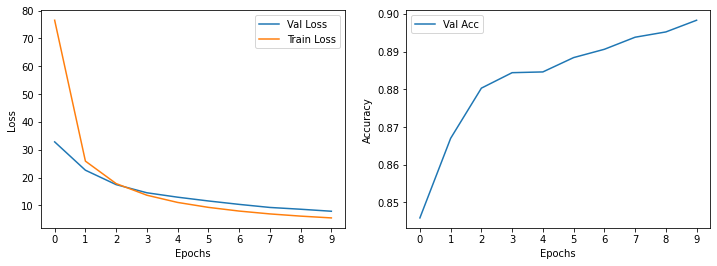

In [19]:
plot_results(history).show()

In [20]:
preds = net.predict(x_test)

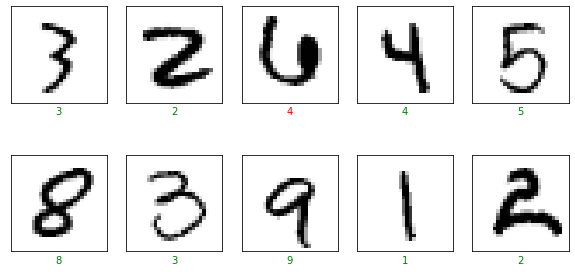

In [21]:
plot_random_examples(x_test, y_test, preds.numpy()).show()